**Python for Economists** - LMAEM - Final Assignment 25/06/2024

  **Members:**
*   Ciro Spallitta 1140660
*   Francesco Colzi 1127782
*   Roberto Vacante 1131429

**Warning:**

The scraping routine requires around 40 minutes to be completed. To ensure that every part of the script runs as intended, the dataframe can be loaded from a .csv at the top of each section.

In [ ]:
#Libraries
import sys
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import geopandas as gpd
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

**Webscraping**

What are we looking for:
*   Data for top 500 world players (excluding goalkeepers as they rely on different statistics)

Steps:
1.  Access Transfermarkt to collect the links corresponding to player profiles
2.  Access profile links to extract player attributes
3.  Store information into dataframe
4.  Clean dataframe for better readability


In [ ]:
#Headers definition
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'TE': 'Trailers'
}

In [ ]:
#List for storing player profile links
list_player = []
pages = 20   #Pages to scrape

# Base link for most valuable players
base_url = "https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop/"
# Loop through each page
for i in range(1, pages + 1):
    page_url = "mw/appunica/page/9/page/7/page/10/page/6//page/" + str(i) #Page identifier
    url = base_url + page_url
    webpage = requests.get(url, headers=headers)
    page_content = BeautifulSoup(webpage.content, 'html.parser')
    # Find all inline-table elements and loop through them to extract profile link
    items = page_content.find_all('table', class_='inline-table')
    for table in items:
        # Find the tag within the inline-table corresponding to the profile href:
        profile_link_tag = table.find('a', title=True, href=True)
        if profile_link_tag:
            profile_link = profile_link_tag['href']   #Save profile string (Example: '/lautaro-martinez/profil/spieler/406625')
            list_player.append(profile_link)

print("Found", len(list_player), "player profiles")

[<table class="inline-table"><tr><td rowspan="2"><a href="#"><img alt="Jude Bellingham" class="bilderrahmen-fixed" src="https://img.a.transfermarkt.technology/portrait/small/581678-1693987944.jpg?lm=1" title="Jude Bellingham"/></a></td><td class="hauptlink"><a href="/jude-bellingham/profil/spieler/581678" title="Jude Bellingham">Jude Bellingham</a></td></tr><tr><td>Attacking Midfield</td></tr></table>, <table class="inline-table"><tr><td rowspan="2"><a href="#"><img alt="Erling Haaland" class="bilderrahmen-fixed" src="https://img.a.transfermarkt.technology/portrait/small/418560-1709108116.png?lm=1" title="Erling Haaland"/></a></td><td class="hauptlink"><a href="/erling-haaland/profil/spieler/418560" title="Erling Haaland">Erling Haaland</a></td></tr><tr><td>Centre-Forward</td></tr></table>, <table class="inline-table"><tr><td rowspan="2"><a href="#"><img alt="Vinicius Junior" class="bilderrahmen-fixed" src="https://img.a.transfermarkt.technology/portrait/small/371998-1664869583.jpg?lm=

KeyboardInterrupt: 

In [ ]:
#Set base link and list to store players data
homepage = "https://www.transfermarkt.com"
players_data = []
i=0

#Loop for data collection
for f in list_player:
  if f == "#":  #Skip invalid links
    continue
  # Define profile link (Example: https://www.transfermarkt.com/lautaro-martinez/profil/spieler/406625)
  url = homepage + f
  webpage = requests.get(url, headers=headers)
  page_content = BeautifulSoup(webpage.content, 'html.parser')

  # Print scraping progress
  i+=1
  sys.stdout.write("\rScraping player %i/500 " % i)
  sys.stdout.flush()

  # Extract name
  name_tag = page_content.find('h1', class_='data-header__headline-wrapper')
  name = name_tag.get_text(strip=True) if name_tag else 'N/A'

  # Extract height
  height_tag = page_content.find('span', itemprop='height')
  height = height_tag.get_text(strip=True) if height_tag else 'N/A'

  # Extract country
  country_tag = page_content.find('span', itemprop='nationality')
  country = country_tag.get_text(strip=True) if country_tag else 'N/A'

  # Extract position
  position_tag = page_content.find('span', string='Position:').find_next('span')
  position = position_tag.get_text(strip=True) if position_tag else 'N/A'
  # Skip goalkeepers as they are valued on different statistics
  if position == "Goalkeeper":
    print(" Skipped player", i, "(Goalkeeper)")
    continue

  # Extract age
  age_tag = page_content.find('span', itemprop='birthDate')
  age = age_tag.get_text(strip=True) if age_tag else 'N/A'

  # Extract foot
  foot_tag = page_content.find('span', string='Foot:').find_next('span')
  foot = foot_tag.get_text(strip=True) if foot_tag else 'N/A'

  # Extract market value
  market_value_tag = page_content.find('a', class_='data-header__market-value-wrapper')
  market_value = market_value_tag.get_text(strip=True) if market_value_tag else 'N/A'

  # Extract current club
  club_tag = page_content.find('span', itemprop='affiliation')
  club = club_tag.get_text(strip=True) if club_tag else 'N/A'

  ## Define link for details page (Example: https://www.transfermarkt.com/lautaro-martinez/leistungsdatendetails/spieler/406625/)
  # Split the original url
  parts = url.split('/', 4)
  # Insert "leistungsdatendetails/" after the first "/", add filter for 2023/24 season
  url = f"{parts[0]}//{parts[2]}/{parts[3]}/leistungsdatendetails/{parts[4]}/plus/0?saison=2023&verein=&liga=&wettbewerb=&pos=&trainer_id="
  # Remove /profil/
  url = re.sub(r'/profil/', '/', url)
  #print(url)
  webpage = requests.get(url, headers=headers)
  page_content = BeautifulSoup(webpage.content, 'html.parser')

  # Find table content (skip player if no data is found, e.g. for an injured player)
  nodata = page_content.find('span', class_='empty')
  if nodata:
    print(" Skipped player", i, "(Injured)")
    continue
  table = page_content.find('table', class_='items')
  rows = table.find_all('tr')

  # Extract headers
  headers_data = [header.get_text(strip=True) for header in rows[0].find_all('th')]

  # Find row for total statistics:
  total_row = None
  for row in rows[1:]:
      if row.find('td', colspan=True):
          total_row = row
          #break

  # Extract the desired data if the row is found:
  if total_row:
      data = total_row.find_all('td')
      appearances = data[3].get_text(strip=True)
      goals = data[4].get_text(strip=True)
      assists = data[5].get_text(strip=True)
      yellow_cards = data[6].get_text(strip=True).split()[0]
      red_cards = data[6].get_text(strip=True).split()[-1]
      time_played = data[7].get_text(strip=True)[:-1]

  # Structure the extracted data
  data = {
      'Name': name,
      'Height': height,
      'Country': country,
      'Position': position,
      'Age': age,
      'Foot': foot,
      'Market Value': market_value,
      'Current Club': club,
      'Appearances': appearances,
      'Goals': goals,
      'Assists': assists,
      'Yellow Cards': yellow_cards,
      'Red Cards': red_cards,
      'Time': time_played,
  }

  # Append data to the created list
  players_data.append(data)
  ##Uncomment if you want the scraper to sleep
  #time.sleep(1)

print(" ...Done!")

Scraping player 166/500  Skipped player 166 (Goalkeeper)
Scraping player 170/500  Skipped player 170 (Goalkeeper)
Scraping player 178/500  Skipped player 178 (Goalkeeper)
Scraping player 191/500  Skipped player 191 (Goalkeeper)
Scraping player 213/500  Skipped player 213 (Goalkeeper)
Scraping player 234/500  Skipped player 234 (Goalkeeper)
Scraping player 235/500  Skipped player 235 (Goalkeeper)
Scraping player 237/500  Skipped player 237 (Goalkeeper)
Scraping player 238/500  Skipped player 238 (Goalkeeper)
Scraping player 296/500  Skipped player 296 (Goalkeeper)
Scraping player 334/500  Skipped player 334 (Goalkeeper)
Scraping player 335/500  Skipped player 335 (Goalkeeper)
Scraping player 336/500  Skipped player 336 (Goalkeeper)
Scraping player 337/500  Skipped player 337 (Goalkeeper)
Scraping player 338/500  Skipped player 338 (Goalkeeper)
Scraping player 367/500  Skipped player 367 (Goalkeeper)
Scraping player 373/500  Skipped player 373 (Injured)
Scraping player 379/500  Skipped p

In [ ]:
# Create a dataframe from the collected data
df = pd.DataFrame(players_data)
display(df)

#Save .csv as a backup
df.to_csv('football_raw.csv', index=False)

,Name,Height,Country,Position,Age,Foot,Market Value,Current Club,Appearances,Goals,Assists,Yellow Cards,Red Cards,Time
0,#5JudeBellingham,"1,86 m",England,Midfield - Attacking Midfield,"Jun 29, 2003 (21)",right,"€180.00mLast update: Jun 7, 2024",Real Madrid,42,23,13,9,1,3.644
1,#9ErlingHaaland,"1,95 m",Norway,Attack - Centre-Forward,"Jul 21, 2000 (23)",left,"€180.00mLast update: May 27, 2024",Man City,45,38,6,1,-,3.745
2,#7Vinicius Junior,"1,76 m",Brazil,Attack - Left Winger,"Jul 12, 2000 (23)",right,"€180.00mLast update: Jun 7, 2024",Real Madrid,39,24,11,11,-,3.084
3,#10KylianMbappé,"1,78 m",France,Attack - Centre-Forward,"Dec 20, 1998 (25)",right,"€180.00mLast update: Jun 3, 2024",Real Madrid,48,44,10,5,-,3.869
4,#47PhilFoden,"1,71 m",England,Attack - Right Winger,"May 28, 2000 (24)",left,"€150.00mLast update: May 27, 2024",Man City,53,27,12,3,-,4.276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,#4MaxenceLacroix,"1,90 m",France,Defender - Centre-Back,"Apr 6, 2000 (24)",right,"€20.00mLast update: May 29, 2024",VfL Wolfsburg,31,4,1,4,2,2.665
470,#15YoussefEn-Nesyri,"1,92 m",Morocco,Attack - Centre-Forward,"Jun 1, 1997 (27)",left,"€20.00mLast update: Jun 7, 2024",Sevilla FC,41,20,3,4,-,3.243
471,#12Caio Henrique,"1,78 m",Brazil,Defender - Left-Back,"Jul 31, 1997 (26)",left,"€20.00mLast update: Jun 3, 2024",Monaco,9,-,5,-,-,625
472,#14Jean-PhilippeMateta,"1,92 m",France,Attack - Centre-Forward,"Jun 28, 1997 (27)",right,"€20.00mLast update: May 27, 2024",Crystal Palace,39,19,5,5,-,2.574


Data Cleaning

In [ ]:
df = pd.read_csv('forwarder_partial.csv')

In [ ]:
# Function to clean the player data
def clean_player_data(player_data):
    # Name:
    if 'Name' in player_data and player_data['Name'] != 'N/A':
        # Remove the '#' and any leading numbers
        name = re.sub(r'^#\d+', '', player_data['Name'])
        # Add space before uppercase letters and strip excess spaces
        name = re.sub(r'([A-Z])', r' \1', name).strip()
        player_data['Name'] = name
    else:
        player_data['Name'] = None

    # Height: convert from m to cm
    if 'Height' in player_data and player_data['Height'] != 'N/A':
        height_str = player_data['Height'].replace(' m', '').replace(',', '.')
        player_data['Height'] = int(float(height_str) * 100)
    else:
        player_data['Height'] = None

    # Position: keep only the first word
    if 'Position' in player_data and player_data['Position'] != 'N/A':
        player_data['Position'] = player_data['Position'].split()[0]
    else:
        player_data['Position'] = None

    # Age:  extract number from parentheses
    if 'Age' in player_data and player_data['Age'] != 'N/A':
        age_str = player_data['Age']
        age_number = age_str.split('(')[-1].replace(')', '').strip()
        player_data['Age'] = int(age_number)
    else:
        player_data['Age'] = None

    # Clean market value
    if 'Market Value' in player_data and player_data['Market Value'] != 'N/A':
        player_data['Market Value'] = clean_market_value(player_data['Market Value'])
    else:
        player_data['Market Value'] = None

    return player_data

# Function to clean market value
def clean_market_value(market_value):
    # Extracting the number using regular expression
    value = re.search(r'€([\d.]+)m', market_value)
    if value:
        return value.group(1)  # Extracting the matched number
    else:
        return None

# Clean each row in the DataFrame
df_cleaned = df.apply(clean_player_data, axis=1)
# Goals (numeric)
df_cleaned['Goals'] = df_cleaned['Goals'].replace('-','0').astype(int)
# Save into file as a backup
df_cleaned.to_csv('football.csv', index=False)

AttributeError: 'int' object has no attribute 'replace'

In [ ]:
display(df_cleaned)

,Name,Height,Country,Position,Age,Foot,Market Value,Current Club,Appearances,Goals,Assists,Yellow Cards,Red Cards,Time,Market Value LN,Position_Defender,Position_Midfield
0,Jude Bellingham,186,England,Midfield,21,right,180.0,Real Madrid,42,23,13.0,9,1,3644.0,19.008467,0,1
1,Erling Haaland,195,Norway,Attack,23,left,180.0,Man City,45,38,6.0,1,-,3745.0,19.008467,0,0
2,Vinicius Junior,176,Brazil,Attack,23,right,180.0,Real Madrid,39,24,11.0,11,-,3084.0,19.008467,0,0
3,Kylian Mbappé,178,France,Attack,25,right,180.0,Real Madrid,48,44,10.0,5,-,3869.0,19.008467,0,0
4,Phil Foden,171,England,Attack,24,left,150.0,Man City,53,27,12.0,3,-,4276.0,18.826146,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,Maxence Lacroix,190,France,Defender,24,right,20.0,VfL Wolfsburg,31,4,1.0,4,2,2665.0,16.811243,1,0
470,Youssef En- Nesyri,192,Morocco,Attack,27,left,20.0,Sevilla FC,41,20,3.0,4,-,3243.0,16.811243,0,0
471,Caio Henrique,178,Brazil,Defender,26,left,20.0,Monaco,9,0,5.0,-,-,625.0,16.811243,1,0
472,Jean- Philippe Mateta,192,France,Attack,27,right,20.0,Crystal Palace,39,19,5.0,5,-,2574.0,16.811243,0,0


In [ ]:
df_cleaned=df_cleaned[df_cleaned['Position']=='Attack']

**Descriptive Analysis**
* Plots (Pie Charts, Histograms, Scatterplots)
* Tables

In [ ]:
df_cleaned = pd.read_csv('forwarder_partial.csv')

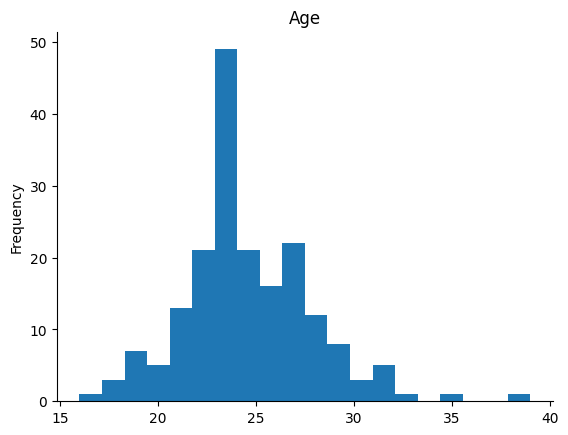

In [ ]:
# @title Age Distribution

from matplotlib import pyplot as plt
df_cleaned['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

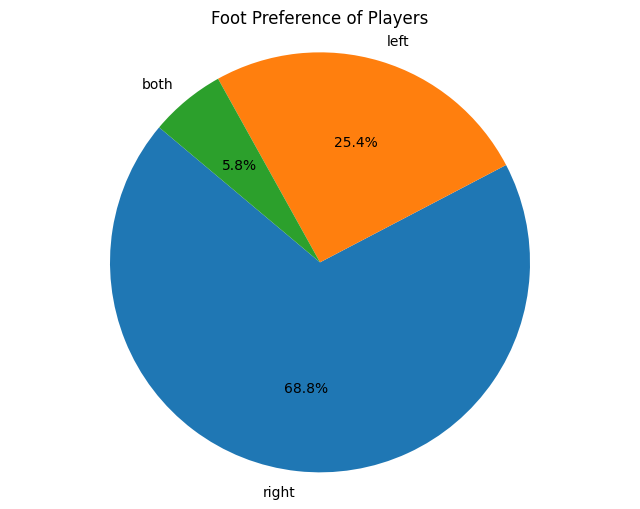

In [ ]:
# @title Foot Preference of Players

import matplotlib.pyplot as plt

# Count the frequency of each foot category
foot_counts = df_cleaned['Foot'].value_counts()

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(foot_counts, labels=foot_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Foot Preference of Players')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


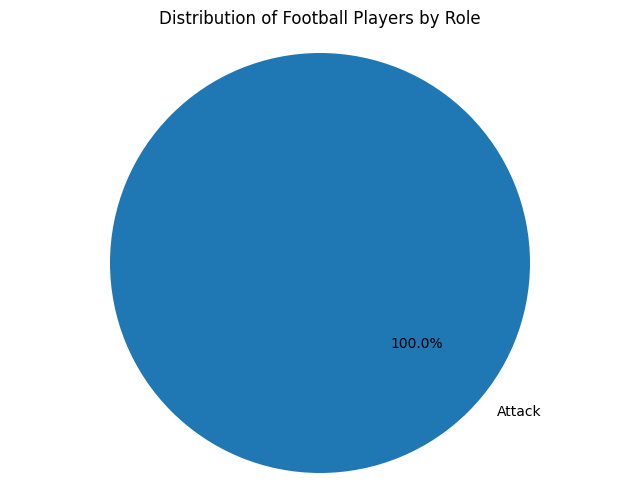

In [ ]:
# @title Player Distribution by Position

import matplotlib.pyplot as plt

# Count the frequency of each role
role_counts = df_cleaned["Position"].value_counts()

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(role_counts, labels=role_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Football Players by Role')
plt.axis('equal')
plt.show()

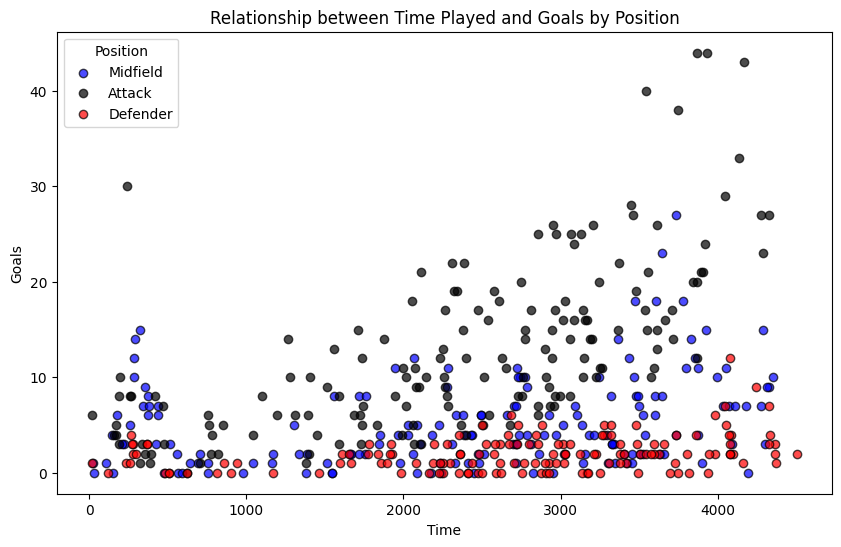

In [ ]:
# @title Relationship between Time Played and Goals by Position
# @markdown All else equal, strikers scome much more than the other players. This difference gets more evident as time played increases.

import matplotlib.pyplot as plt
import pandas as pd

# Function to remove '.' from thousands
df_cleaned['Time'] = df_cleaned['Time'].astype(str)
def correct_thousands(time_str):
    if '.' in time_str:
        parts = time_str.split('.')
        if len(parts[0]) == 1:  # Check if the integer part has 1 digits
            return parts[0] + parts[1]
    return time_str

# Apply the function to the 'Time' column
df_cleaned['Time'] = df_cleaned['Time'].apply(correct_thousands)
df_cleaned['Time'] = pd.to_numeric(df_cleaned['Time'], errors="coerce")
df_cleaned['Goals'] = pd.to_numeric(df_cleaned['Goals'], errors="coerce")

# Extract relevant columns
data = df_cleaned[['Position', 'Goals', 'Assists', 'Height', 'Yellow Cards', 'Market Value', 'Time']]

# Create a plot
plt.figure(figsize=(10, 6))

# Define colors for each position
colors = {
    'Attack': 'black',
    'Midfield': 'blue',
    'Defender': 'red',
}

# Plot each position with a different color
for i, pos in enumerate(data['Position'].unique()):
    plt.scatter(
        x=data.loc[data['Position'] == pos, 'Time'],
        y=data.loc[data['Position'] == pos, 'Goals'],
        label=pos,
        color=colors.get(pos, 'grey'),  # Default to a standard color if not specified
        edgecolor='black',
        alpha=0.7
    )

# Add labels and title
plt.title('Relationship between Time Played and Goals by Position')
plt.xlabel('Time')
plt.ylabel('Goals')

# Add legend
plt.legend(title='Position')
plt.show()


<ipython-input-72-cd1db44771da>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_cleaned, x='Height', y='Position', inner='stick', palette='Dark2')


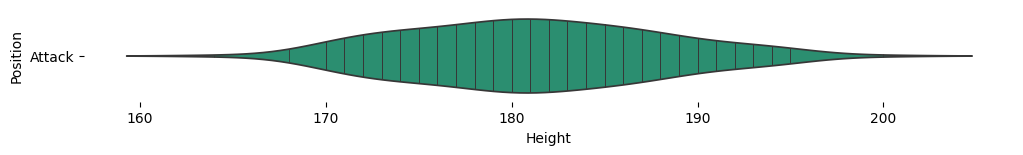

In [ ]:
# @title Violin plot of Player Height by Position
# @markdown Interestingly, we can observe that defenders are taller on average than the other players

from matplotlib import pyplot as plt
import seaborn as sns

# Violin plot
figsize = (12, 1.2 * len(df_cleaned['Position'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_cleaned, x='Height', y='Position', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# @title Top Teams based on player average market value
# @markdown **Remark:** judging from real data, it is evident that these results may suffer from selection bias, as the sample is limited to only the top 500 players.

#Display Top Teams based on player average market value

# Group by 'Current Club' and sum the 'Market Value' for each team
df_cleaned['Market Value'] = pd.to_numeric(df_cleaned['Market Value'], errors='coerce')
team_market_values = df_cleaned.groupby('Current Club')['Market Value'].mean()
# Sort the teams by the total market value in descending order
sorted_teams = team_market_values.sort_values(ascending=False)

# Get the top 10 teams
top_teams = sorted_teams.head(10)
print(top_teams)

Current Club
Real Madrid      180.000000
Man City          96.000000
Inter             65.000000
Arsenal           55.000000
RB Leipzig        55.000000
Bayern Munich     52.428571
West Ham          50.000000
Liverpool         50.000000
Paris SG          45.000000
Man Utd           45.000000
Name: Market Value, dtype: float64


**Geographical Analysis**
* World Map highlighting the frequency of player nationalities
* Wordcloud

In [ ]:
df_cleaned = pd.read_csv('forwarder_partial.csv')

<ipython-input-76-2e17f690aedc>:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


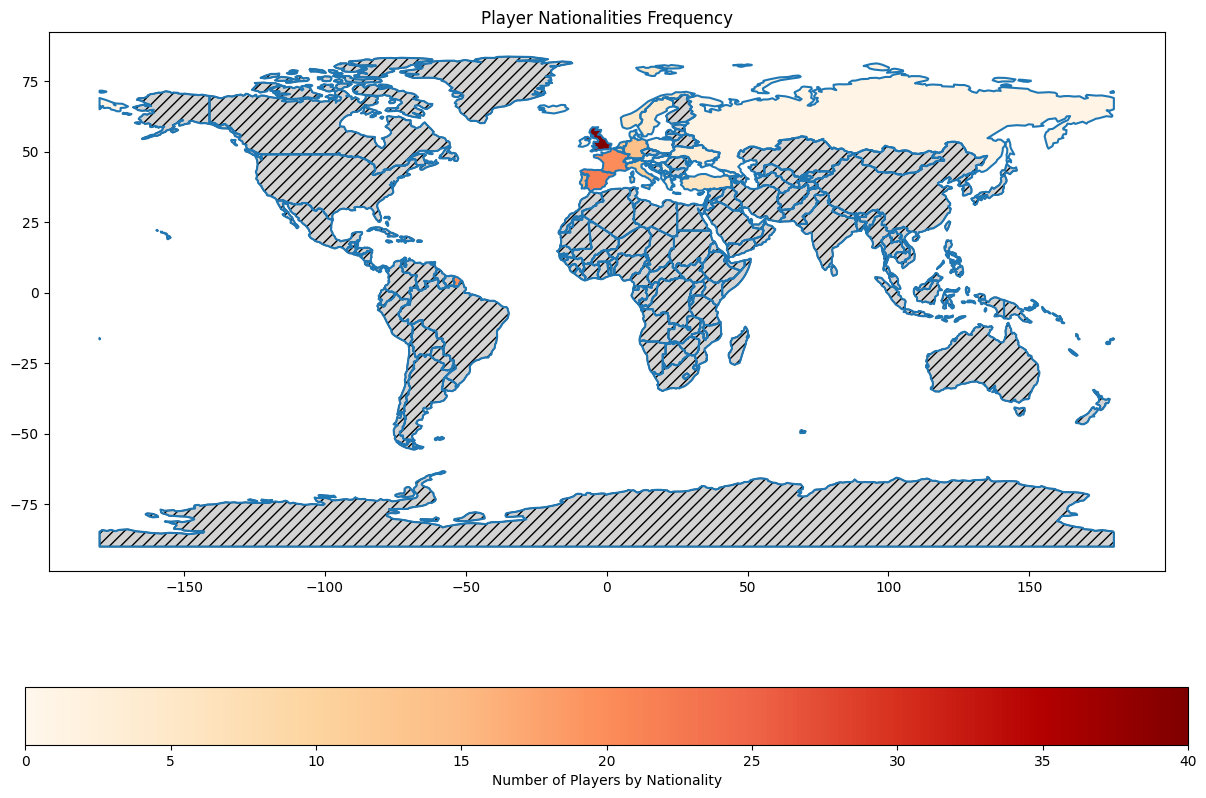

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a separate DataFrame to manipulate geographical information to match the geopandas identifiers
df_geo = df_cleaned
df_geo['Country'] = df_geo['Country'].replace('United States', 'United States of America')
df_geo['Country'] = df_geo['Country'].replace(dict.fromkeys(['England','Scotland','Wales'], 'United Kingdom'))
df_geo['Country'] = df_geo['Country'].replace('Türkiye', 'Turkey')
df_geo['Country'] = df_geo['Country'].replace('Cote d\'Ivoire', 'Ivory Coast')
df_geo['Country'] = df_geo['Country'].replace('Korea, South', 'South Korea')

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Count the frequency of each nationality
nationality_counts = df_geo['Country'].value_counts()
# Merge nationality counts with world map data
world = world.merge(nationality_counts, how='left', left_on='name', right_index=True)

# Fill NaN values (countries with no players) with 0
world['count'] = world['count'].fillna(0)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='count', ax=ax, legend=True, cmap='OrRd',
           legend_kwds={'label': "Number of Players by Nationality",
                        'orientation': "horizontal"})

# Highlight countries with no top players with bars
world[world['count'] == 0].plot(ax=ax, color='lightgray', hatch='///', edgecolor='black')
plt.title('Player Nationalities Frequency')
plt.show()


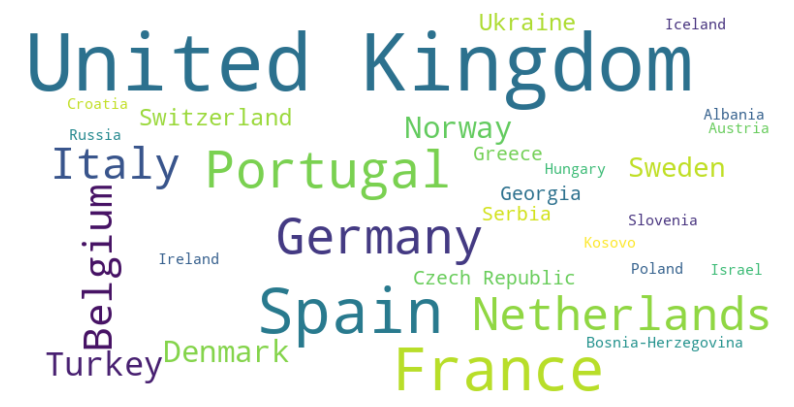

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter


# Define text from country data
text = df_geo['Country'].astype(str)
# Count country frequency and generate wordcloud from frequencies in order to treat multiple word strings as a single word
count = Counter(text)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', collocations=False).generate_from_frequencies(count)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**Econometrics**

Multiple Linear Regression on Market Value (log)
1.  Defining log(Market Value) and Position dummies
2.  Convert variables to numeric format and drop missing values
3.  Print OLS results

In [ ]:
df_cleaned = pd.read_csv('forwarder.csv')

In [ ]:
# @title
import numpy as np

# Log-scale market value
df_cleaned["Market Value"] = pd.to_numeric(df_cleaned["Market Value"], errors='coerce')
df_cleaned["Market Value LN"] = np.log(pd.to_numeric(df_cleaned["Market Value"]) * 1000000)

# Position dummies
#dummies = pd.get_dummies(df_cleaned['Position'], prefix='Position', drop_first=True)
#df_cleaned = pd.concat([df_cleaned, dummies], axis=1)
# Ensure dummy variables are integers (0/1 instead of True/False)
#dummy_cols = [col for col in df_cleaned.columns if col.startswith('Position_')]
#df_cleaned[dummy_cols] = df_cleaned[dummy_cols].astype(int)

dummies = pd.get_dummies(df_cleaned['League'], prefix='League', drop_first=True)
df_cleaned = pd.concat([df_cleaned, dummies], axis=1)
# Ensure dummy variables are integers (0/1 instead of True/False)
dummy_cols = [col for col in df_cleaned.columns if col.startswith('League_')]
df_cleaned[dummy_cols] = df_cleaned[dummy_cols].astype(int)

# Convert attributes to numeric
df_cleaned['Appearances'] = pd.to_numeric(df_cleaned['Appearances'], errors='coerce')
df_cleaned['Height'] = pd.to_numeric(df_cleaned['Height'], errors='coerce')
df_cleaned['Age'] = pd.to_numeric(df_cleaned['Age'], errors='coerce')
df_cleaned['Goals'] = pd.to_numeric(df_cleaned['Goals'], errors='coerce')
df_cleaned['Assists'] = pd.to_numeric(df_cleaned['Assists'], errors='coerce')

# Remove '.' from Time
df_cleaned['Time'] = df_cleaned['Time'].astype(str)
def correct_thousands(time_str):
    if '.' in time_str:
        parts = time_str.split('.')
        if len(parts[0]) == 1:  # Check if the integer part has 1 digits
            return parts[0] + parts[1]
    return time_str

# Apply the function to the 'Time' column
df_cleaned['Time'] = df_cleaned['Time'].apply(correct_thousands)
df_cleaned['Time'] = pd.to_numeric(df_cleaned['Time'], errors="coerce")

# Drop rows with missing values
df_cleaned = df_cleaned.fillna(value={'Market Value': 0, 'Height': 0, 'Age': 0, 'Goals': 0, 'Assists': 0, 'Time': 0, 'Appearances': 0})

df_cleaned.head(5)

,Name,Height,Country,Position,Age,Foot,Market Value,Current Club,League,Appearances,Goals,Assists,Yellow Cards,Red Cards,Time,Market Value LN,League_LaLiga,League_Liga Portugal,League_Premier League,League_Serie A
0,Erling Haaland,195,Norway,Attack,23,right,180.0,Man City,Premier League,45,38,6,1,-,3745,19.008467,0,0,1,0
1,Vinicius Junior,176,Brazil,Attack,23,right,180.0,Real Madrid,LaLiga,39,24,11,11,-,3084,19.008467,1,0,0,0
2,Kylian Mbappé,178,France,Attack,25,right,180.0,Real Madrid,LaLiga,48,44,10,5,-,3869,19.008467,1,0,0,0
3,Phil Foden,171,England,Attack,24,right,150.0,Man City,Premier League,53,27,12,3,-,4276,18.826146,0,0,1,0
4,Bukayo Saka,178,England,Attack,22,right,140.0,Arsenal,Premier League,47,20,14,4,-,3865,18.757153,0,0,1,0


In [ ]:
# @title Multiple Linear Regression on Market Value (in log)

import pandas as pd
import numpy as np
import statsmodels.api as sm

df_cleaned['Age Squared'] = (df_cleaned['Age'] * df_cleaned['Age'])

# Define the independent variables and the dependent variable
X = df_cleaned[['Age', 'Age Squared',  'Height', 'Goals', 'Assists', 'Time'] + dummy_cols]
y = df_cleaned['Market Value LN']

# Add a constant to the independent variables (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Market Value LN   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     96.14
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           8.19e-86
Time:                        14:44:09   Log-Likelihood:                 111.54
No. Observations:                 300   AIC:                            -201.1
Df Residuals:                     289   BIC:                            -160.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    17.06

In [ ]:
df['ruolo'].value_counts()

**Remark**: results may vary depending on when the sample was scraped, as market values are subject to daily changes. We found results to be consistent across different regression runs. Current analysis is based on the attached .csv (last updated on 24/06).

Results for the regression generally show a positive relationship between Market Value and player performance (Goals, Assists), with a p-value well below 5%.

The direction of the Age coefficient seems to be sample sensitive, tending to be slightly positive or negative.

Time and Height show no significance regardless of the sample.

Position dummies highlight a positive effect on Market Value. Ceteris paribus, it is intuitive that a defender scoring the same number of goals as an attacker is clearly more valuable.

Clearly, as the R-squared of the regression is low, other covariates (e.g. sponsorships, transfers, past performance) may be influencing Market Value. Hence, results may well be misleading at this stage.


**Machine Learning**

Split dataset into training and testing dataset for prediction of Market Value.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Selecting features and target
X = df_cleaned[['Age', 'Age Squared',  'Height', 'Goals', 'Assists', 'Time'] + dummy_cols] # Features
y = df_cleaned['Market Value']            # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 333.5221381602017
R-squared: 0.7365337991024232


Mean Squared Error: 499.6789891981218
R^2 Score: 0.6761450252070198


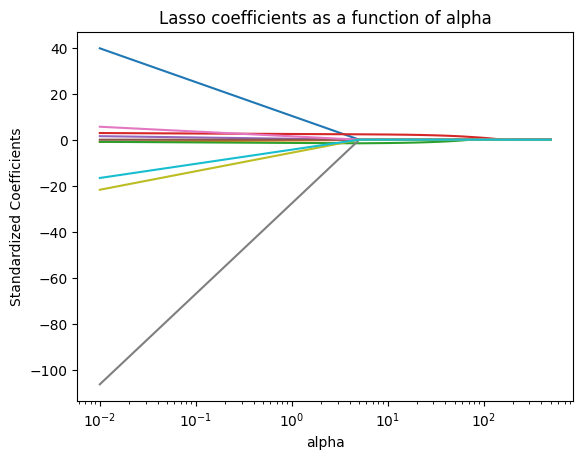

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Selecting features and target
X = df_cleaned[['Age', 'Age Squared',  'Height', 'Goals', 'Assists', 'Time'] + dummy_cols]  # Features
y = df_cleaned['Market Value']            # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crea il modello di regressione Lasso
lasso = Lasso(alpha=1.0)  # Puoi modificare il parametro alpha per regolare la forza della penalizzazione

# Allena il modello
lasso.fit(X_train_scaled, y_train)

# Fai previsioni sui dati di test
y_pred = lasso.predict(X_test_scaled)

# Valuta il modello
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

alphas = np.linspace(0.01,500,100)
lasso1 = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso1.set_params(alpha=a)
    lasso1.fit(X_train, y_train)
    coefs.append(lasso1.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Lasso(alpha=12.835629774305561)
R squared training set 0.5
R squared test set 0.51


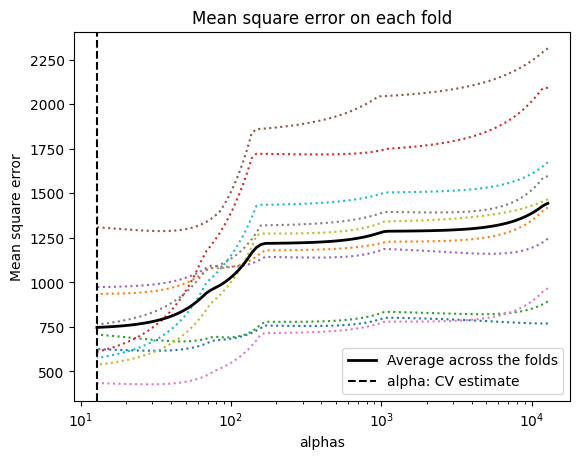

In [ ]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=10, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

model.alpha_

# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)
print(lasso_best)
print('R squared training set', round(lasso_best.score(X_train, y_train), 2))
print('R squared test set', round(lasso_best.score(X_test, y_test), 2))

mean_squared_error(y_test, lasso_best.predict(X_test))

plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 0, 2000


In [ ]:
# Get input from user
def get_user_input():
    age = int(input("Enter Age: "))
    goals = int(input("Enter Goals: "))
    assists = int(input("Enter Assists: "))
    time = int(input("Enter Time (in minutes): "))
    return {'Age': [age], 'Goals': [goals], 'Assists': [assists], 'Time': [time]}
user_input = get_user_input()

# Convert input to DataFrame
input_df = pd.DataFrame(user_input)

# Predict market value (in million euros)
predicted_value = model.predict(input_df)
print(f'Predicted Market Value (€mln): {predicted_value[0]}')


Enter Age: 25
Enter Goals: 35
Enter Assists: 10
Enter Time (in minutes): 2500


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Appearances
- Height


Prediction performance seems to be unreliable with respect to actual data, possibly because the training and testing samples are too small to reflect the player population.

As seen earlier, Market Value may also depend on many other factors not included in this analysis, preventing an accurate prediction.









In [ ]:
conteggi = df_cleaned['League'].value_counts()

print(conteggi)

League
Premier League    144
Serie A            72
LaLiga             48
Bundesliga         24
Liga Portugal      12
Name: count, dtype: int64
